In [1]:
import warnings

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier

from get_data import get_balanced_exoplanet_data, get_scaled_balanced_exoplanet_data

warnings.simplefilter("ignore")

In [2]:
x_train, x_test, y_train, y_test = get_balanced_exoplanet_data()
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = get_scaled_balanced_exoplanet_data()

## Try without scaling

0.9737623762376237


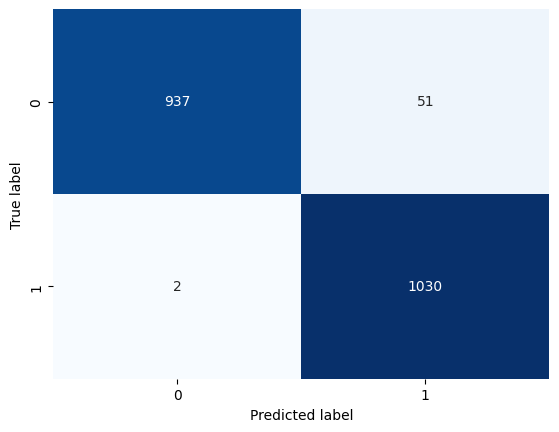

In [3]:
# Parameters
rng_seed = 2023  # random number generator seed
eta_0 = 0.1  # starting learning rate
n_nodes = [10]  # hidden layer nodes
activation = "relu"  # hidden activation
n_epochs = 100  # number of epochs
lmbda = 0.001  # l2 regularization
solver = "adam"  # solver algorithm


model = MLPClassifier(
    hidden_layer_sizes=n_nodes,
    solver=solver,
    activation=activation,
    alpha=lmbda,
    learning_rate_init=eta_0,
    max_iter=n_epochs,
    random_state=rng_seed,
)
model.fit(x_train, y_train)
pred = model.predict(x_test)

# Confusion matrix
sns.heatmap(
    confusion_matrix(y_test, pred),
    annot=True,
    cmap="Blues",
    cbar=False,
    fmt=".0f",
)
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Metrics
print(accuracy_score(y_test, pred))

## Try with scaling

0.9905940594059406


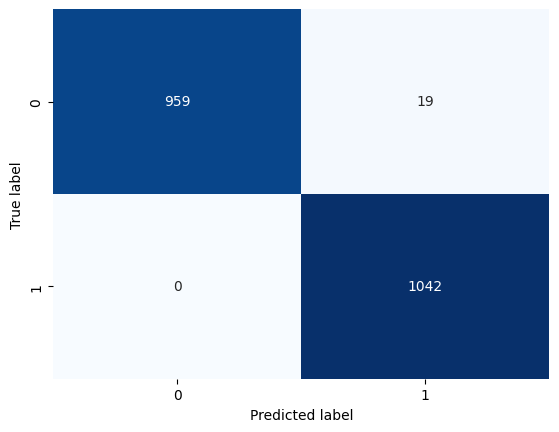

In [4]:
model = MLPClassifier(
    hidden_layer_sizes=n_nodes,
    solver=solver,
    activation=activation,
    alpha=lmbda,
    learning_rate_init=eta_0,
    max_iter=n_epochs,
    random_state=rng_seed,
)

model.fit(x_train_scaled, y_train_scaled)
pred = model.predict(x_test_scaled)

# Confusion matrix
sns.heatmap(
    confusion_matrix(y_test_scaled, pred),
    annot=True,
    cmap="Blues",
    cbar=False,
    fmt=".0f",
)
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Metrics
print(accuracy_score(y_test_scaled, pred))

#### Scaling improves performance

## Try more than one hidden layer

0.5064356435643564


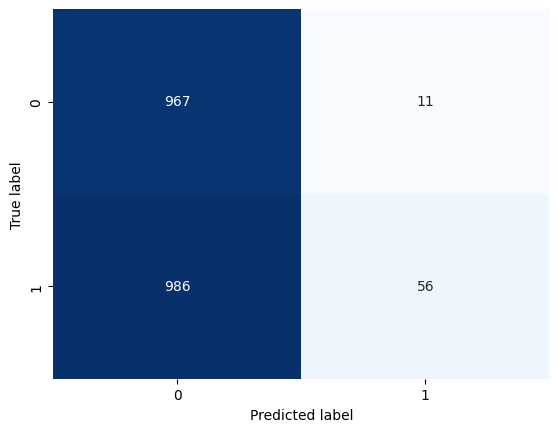

In [6]:
# Parameters
n_nodes2 = [10, 10, 10]  # hidden layer nodes

model = MLPClassifier(
    hidden_layer_sizes=n_nodes2,
    solver=solver,
    activation=activation,
    alpha=lmbda,
    learning_rate_init=eta_0,
    max_iter=n_epochs,
    random_state=rng_seed,
)

model.fit(x_train_scaled, y_train_scaled)
pred = model.predict(x_test_scaled)

# Confusion matrix
sns.heatmap(
    confusion_matrix(y_test_scaled, pred),
    annot=True,
    cmap="Blues",
    cbar=False,
    fmt=".0f",
)
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Metrics
print(accuracy_score(y_test_scaled, pred))

### Using one hidden layer is significantly better

## Grid search for parameters $\eta$ and $\lambda$

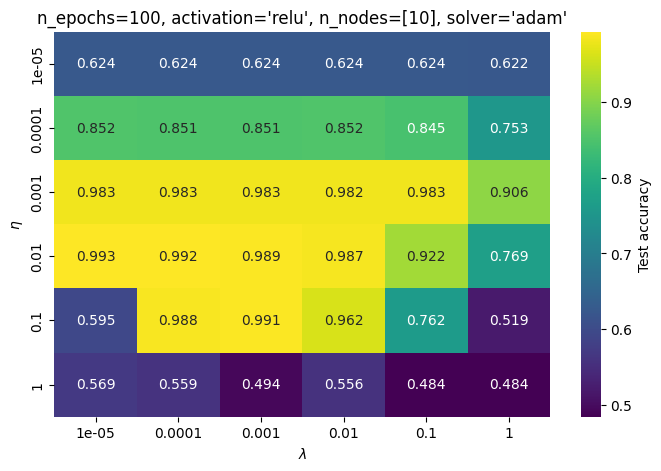

In [7]:
# Parameters
eta_vals = np.logspace(-5, 0, 6)
lmbd_vals = np.logspace(-5, 0, 6)
figsize = 8, 5
filename = "../results/figures/nn_gridsearch_eta_lambda.png"

accuracies = np.zeros((eta_vals.size, lmbd_vals.size))
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        model = MLPClassifier(
            hidden_layer_sizes=n_nodes,
            solver=solver,
            activation=activation,
            alpha=lmbd,
            learning_rate_init=eta,
            max_iter=n_epochs,
            random_state=rng_seed,
        )

        model.fit(x_train_scaled, y_train_scaled)
        pred = model.predict(x_test_scaled)
        accuracies[i, j] = accuracy_score(y_test_scaled, pred)

# heatmap
plt.figure(figsize=figsize)
sns.heatmap(
    accuracies,
    annot=True,
    fmt=".3f",
    xticklabels=[f"{lmbd:g}" for lmbd in lmbd_vals],
    yticklabels=[f"{eta:g}" for eta in eta_vals],
    cbar_kws={"label": "Test accuracy"},
    cmap="viridis",
)
plt.title(f"{n_epochs=}, {activation=}, {n_nodes=}, {solver=}")
plt.xlabel("$\lambda$")
plt.ylabel("$\eta$")

if filename:
    plt.savefig(filename)
plt.show();

## Grid search of parameters n_batches, n_nodes with one layer

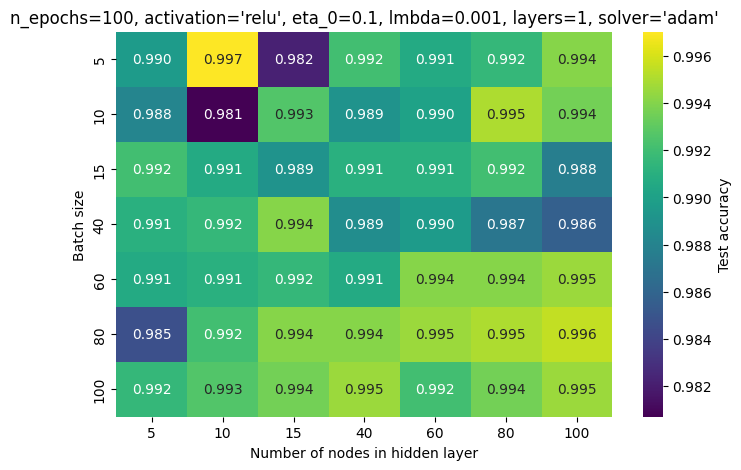

In [10]:
# Parameters
batch_size_vals = [5, 15, 40, 80, 100]  # minibatch size
node_vals = [(5,), (15,), (40,), (80,), (100,)]
figsize = 8, 5
filename = "../results/figures/nn_gridsearch_batches_nodes.png"
eta = 0.01  # starting learning rate
lmb = 1e-5  # l2 regularization

accuracies = np.zeros((len(batch_size_vals), len(node_vals)))
for i, batch_size in enumerate(batch_size_vals):
    for j, nodes in enumerate(node_vals):
        model = MLPClassifier(
            hidden_layer_sizes=nodes,
            solver=solver,
            activation=activation,
            alpha=lmb,
            learning_rate_init=eta,
            max_iter=n_epochs,
            random_state=rng_seed,
            batch_size=batch_size,
        )

        model.fit(x_train_scaled, y_train_scaled)
        pred = model.predict(x_test_scaled)
        accuracies[i, j] = accuracy_score(y_test_scaled, pred)

# heatmap
plt.figure(figsize=figsize)
sns.heatmap(
    accuracies,
    annot=True,
    fmt=".3f",
    xticklabels=[f"{nodes[0]}" for nodes in node_vals],
    yticklabels=[f"{batches}" for batches in batch_size_vals],
    cbar_kws={"label": "Test accuracy"},
    cmap="viridis",
)
plt.title(f"{n_epochs=}, {activation=}, {eta_0=}, {lmbda=}, layers=1, {solver=}")
plt.xlabel("Number of nodes in hidden layer")
plt.ylabel("Batch size")

if filename:
    plt.savefig(filename)
plt.show();